In [1]:
import sys
sys.path.append('../')

import pandas as pd
import geopandas as gpd
from access import access, weights, datasets

# How to Use `access` to Compute Access Scores to Resources Given XY Coordinates Joined to Census Tracts
A common use case for using `access` is to calculate access scores from an origin tract to the aggregated resources available within a destination tract's population weighted centroid. In this notebook, we'll show you how to join your XY coordinates to their Census Tract and use the `access` package with our [pre-computed Travel Cost matricies](https://access.readthedocs.io/en/latest/resources.html) to compute access scores between origin Census Tracts and destination Census tracts. The Travel Cost matrix used in this example is a subset of the national travel cost matrix. We have a notebook on [**How to Subset the Travel Cost Matricies**](./How%20to%20Subset%20the%20Travel%20Cost%20Matricies.ipynb).

We'll show you how to:
- [Join Cook County population data with a geospatial dataset for Cook County Census tracts](#Join-Population-Data-with-Geospatial-Representation-of-Census-Tracts)
- [Load in Cook County Hospital data and create geometric points from the XY coordinates](#Load-Cook-County-Hospital-Data-and-Create-Geometric-Points-from-the-XY-Coordinates)
- [Perform a spatial join between the hospital points and the Cook County Census tracts](#Perform-Spatial-Join-Between-Hospitals-and-Cook-County-Census-Tracts)
- [Calculate access measures using the pre-computed Travel Cost matrix as the cost measure](#Calculate-Access-Measures-Using-Pre-computed-Travel-Cost-Matrix)
- [Save calculated access measures to a CSV](#Saving-Access-Measures-to-a-CSV)

**Note**: In certain cases, we might be interested in measuring access to the exact locations of the resource, such as a hospital or grocery store. While the pre-computed cost matrix would not be useful for this use case, the `access` package can still be used to calculate the euclidean distances from origin tracts' population weighted centroids to the resource located at specific coordinates. See our notebook on [**How to Use access to Compute Access Scores to Resources Given XY Coordinates**](./How%20to%20Use%20access%20%20to%20Compute%20Access%20to%20Locations%20Given%20X%20Y%20Coordinates.ipynb) for an example of this alternate approach.

## Join Population Data with Geospatial Representation of Census Tracts
To complete this first step, we'll need two files:
- Cook County population data at the census tract level
- geospatial representation of Cook County Census Tracts

First, we'll load a dataset containing population counts for Cook County at the Census Tract level.

In [2]:
cook_county_population = datasets.load_data('chi_pop')
cook_county_population.head()

,geoid,pop
0,17031010100,4854
1,17031010201,6450
2,17031010202,2818
3,17031010300,6236
4,17031010400,5042


Next, we'll load in a `.geojson` file of Cook County Census Tracts. ***To see how to produce a `.geojson` file starting from a larger shapefile, see our notebook [How to Subset a Geospatial Shapefile and Convert to .geojson](./How%20to%20Read%2C%20Filter%2C%20and%20Convert%20Shapefiles%20to%20.geojson.ipynb).***

,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA,geoid,geometry
0,1400000US17031440300,17,031,440300,4403,Tract,0.499,17031440300,"POLYGON ((359779.998 563694.900, 359785.854 56..."
1,1400000US17031440600,17,031,440600,4406,Tract,0.259,17031440600,"POLYGON ((359797.310 563086.247, 359800.394 56..."
2,1400000US17031440700,17,031,440700,4407,Tract,0.126,17031440700,"POLYGON ((360201.128 563098.184, 360402.583 56..."
3,1400000US17031460200,17,031,460200,4602,Tract,0.232,17031460200,"POLYGON ((364927.536 564034.757, 365032.657 56..."
4,1400000US17031460600,17,031,460600,4606,Tract,0.101,17031460600,"POLYGON ((364641.501 563219.094, 364699.974 56..."


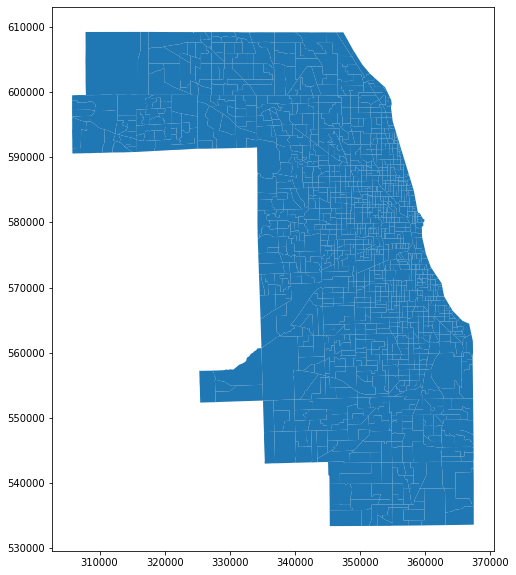

In [3]:
cook_county_tracts = datasets.load_data('cook_county_tracts')
cook_county_tracts.plot(figsize=(10,10))
cook_county_tracts.head()

Now we will join the geospatial representations of Cook County Tracts to the population data and plot the population numbers so that we can see the differences at the tract level.

,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA,geoid,geometry,pop
0,1400000US17031440300,17,031,440300,4403,Tract,0.499,17031440300,"POLYGON ((359779.998 563694.900, 359785.854 56...",4757
1,1400000US17031440600,17,031,440600,4406,Tract,0.259,17031440600,"POLYGON ((359797.310 563086.247, 359800.394 56...",2080
2,1400000US17031440700,17,031,440700,4407,Tract,0.126,17031440700,"POLYGON ((360201.128 563098.184, 360402.583 56...",1545
3,1400000US17031460200,17,031,460200,4602,Tract,0.232,17031460200,"POLYGON ((364927.536 564034.757, 365032.657 56...",2385
4,1400000US17031460600,17,031,460600,4606,Tract,0.101,17031460600,"POLYGON ((364641.501 563219.094, 364699.974 56...",1183


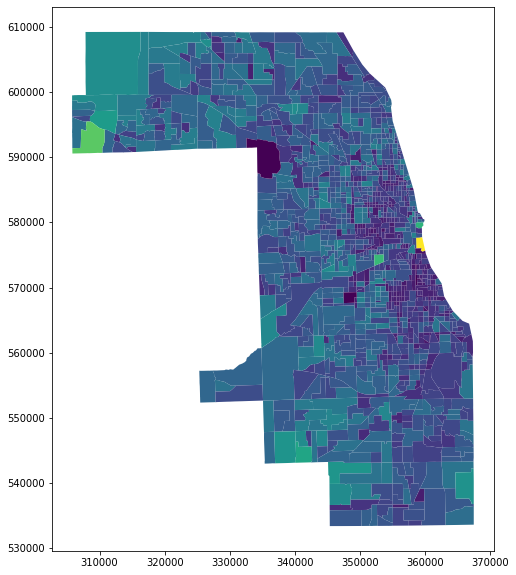

In [4]:
cook_county_geopop = cook_county_tracts.merge(cook_county_population, on='geoid')
cook_county_geopop.plot(column='pop', figsize=(10,10))
cook_county_geopop.head()

## Load Cook County Hospital Data and Create Geometric Points from the XY Coordinates
Next up, well load the hospital data which has an XY coordinate pair for each hospital. Using the XY coordinates, we will create geospatial points which can then be used to calculate the distances between the cencus tracts and hospitals.

As shown below, the dataset contains X and Y coordinates for the locations of the hospitals.

In [5]:
cook_county_hospitals = datasets.load_data('cook_county_hospitals')
cook_county_hospitals.head()

,ADDRESS,CFNAME,CFSUBTYPE,CFTYPE,Community,GNISCODE,Jurisdicti,OBJECTID,SOURCE,COORD_X,COORD_Y
0,9340 S Kostner Ave,Advocate Christ Medical Center,Hospital,Hospital,Oak Lawn,426825.0,NaN,1,CGI,-87.732438,41.722202
1,15300 West Ave,Palos Primary Care Center,Hospital,Hospital,Orland Park,2036658.0,NaN,2,CL,-87.865552,41.610533
2,15901 Cicero Ave,Oak Forest Hospital,Hospital,Hospital,Bremen Twp,414760.0,NaN,3,CEGL,-87.731486,41.599667
3,375 W North Ave,Gottlieb Memorial Hospital,Hospital,Hospital,Melrose Park,409212.0,NaN,4,BCEG,-87.843465,41.910779
4,2100 Pfingsten Rd,Glenbrook Hospital,Hospital,Hospital,Glenview,2033578.0,NaN,5,CEGI,-87.851615,42.092630


Using the dataset above, we can create a [`geopandas.GeoDataFrame`](http://geopandas.org/reference/geopandas.GeoDataFrame.html) and with the `gpd.points_from_xy` create geometric points for each hospital.

In [6]:
cook_county_hospitals_geom = gpd.GeoDataFrame(cook_county_hospitals, 
                                              geometry = gpd.points_from_xy(cook_county_hospitals.COORD_X, 
                                                                            cook_county_hospitals.COORD_Y))
cook_county_hospitals_geom.head()

,ADDRESS,CFNAME,CFSUBTYPE,CFTYPE,Community,GNISCODE,Jurisdicti,OBJECTID,SOURCE,COORD_X,COORD_Y,geometry
0,9340 S Kostner Ave,Advocate Christ Medical Center,Hospital,Hospital,Oak Lawn,426825.0,NaN,1,CGI,-87.732438,41.722202,POINT (-87.73244 41.72220)
1,15300 West Ave,Palos Primary Care Center,Hospital,Hospital,Orland Park,2036658.0,NaN,2,CL,-87.865552,41.610533,POINT (-87.86555 41.61053)
2,15901 Cicero Ave,Oak Forest Hospital,Hospital,Hospital,Bremen Twp,414760.0,NaN,3,CEGL,-87.731486,41.599667,POINT (-87.73149 41.59967)
3,375 W North Ave,Gottlieb Memorial Hospital,Hospital,Hospital,Melrose Park,409212.0,NaN,4,BCEG,-87.843465,41.910779,POINT (-87.84347 41.91078)
4,2100 Pfingsten Rd,Glenbrook Hospital,Hospital,Hospital,Glenview,2033578.0,NaN,5,CEGI,-87.851615,42.092630,POINT (-87.85161 42.09263)


Next, we'll assign a coordinate reference system (CRS) code to the dataset and then we can plot the points.

In [7]:
cook_county_hospitals_geom.crs = {'init':'epsg:4326'}
cook_county_hospitals_geom = cook_county_hospitals_geom.to_crs(epsg=3528)

We can now plot these points on top of the Census Tracts.

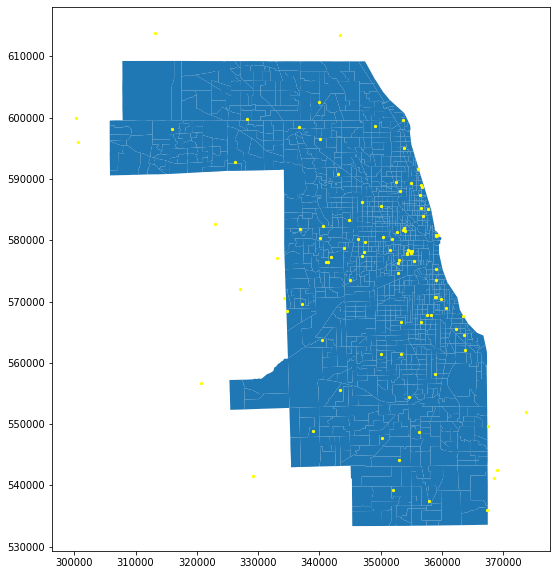

In [8]:
base = cook_county_tracts.plot(figsize=(10,10))
cook_county_hospitals_geom.plot(ax=base, color='yellow', markersize = 5, figsize=(10,10))

## Perform Spatial Join Between Hospitals and Cook County Census Tracts
Having created a geometric representation of each hospital, we can now perform a spatial join between the newly created points and the census tracts to bring in the `geoid` of the Census Tract the hospital is in.

In the next step, we reassign the CRS to the `cook_county_hospitals_geom` dataframe, perform the spatial join, drop a column, and view the newly joined `geoid` column showing the Census Tract that the hospital is located in.

In [9]:
cook_county_hospitals_geom.crs = {'init':'epsg:3528'}
cook_county_hospitals_w_tracts = gpd.sjoin(cook_county_hospitals_geom, cook_county_tracts[['geoid', 'geometry']], how='inner', op='intersects')
cook_county_hospitals_w_tracts = cook_county_hospitals_w_tracts.drop(columns=['index_right'])
cook_county_hospitals_w_tracts.head()

,ADDRESS,CFNAME,CFSUBTYPE,CFTYPE,Community,GNISCODE,Jurisdicti,OBJECTID,SOURCE,COORD_X,COORD_Y,geometry,geoid
0,9340 S Kostner Ave,Advocate Christ Medical Center,Hospital,Hospital,Oak Lawn,426825.0,NaN,1,CGI,-87.732438,41.722202,POINT (349999.428 561422.673),17031822102
1,15300 West Ave,Palos Primary Care Center,Hospital,Hospital,Orland Park,2036658.0,NaN,2,CL,-87.865552,41.610533,POINT (338990.545 548951.525),17031824116
2,15901 Cicero Ave,Oak Forest Hospital,Hospital,Hospital,Bremen Twp,414760.0,NaN,3,CEGL,-87.731486,41.599667,POINT (350173.710 547813.914),17031825200
3,375 W North Ave,Gottlieb Memorial Hospital,Hospital,Hospital,Melrose Park,409212.0,NaN,4,BCEG,-87.843465,41.910779,POINT (340641.610 582308.963),17031811302
4,2100 Pfingsten Rd,Glenbrook Hospital,Hospital,Hospital,Glenview,2033578.0,NaN,5,CEGI,-87.851615,42.092630,POINT (339851.861 602503.437),17031801607


## Calculate Access Measures Using Pre-computed Travel Cost Matrix
Now that we our origin and destination locations set, we can bring in the pre-computed Travel Cost matrix and create an instance of the `access` object.

As a reminder, the Travel Cost matrix being read in below is a subset of the national pre-computed Travel Cost matrix, and you can reference our notebook on [**How to Subset the Travel Cost Matricies**](./How%20to%20Subset%20the%20Travel%20Cost%20Matricies.ipynb) to do the same.

In [10]:
cook_cost_matrix = datasets.load_data('chi_times')
cook_cost_matrix.head()

,origin,dest,cost
0,17093890101,17031010100,91.20
1,17093890101,17031010201,92.82
2,17093890101,17031010202,92.95
3,17093890101,17031010300,89.40
4,17093890101,17031010400,84.97


Our points of demand origin are the Census Tracts tied to population counts and the supply destinations are the Census Tracts that have hospitals. 

In [11]:
cook_hospital_access = access(demand_df    = cook_county_geopop, 
                              demand_index = 'geoid', 
                              demand_value = 'pop',
                              supply_df    = cook_county_hospitals_w_tracts, 
                              supply_index = 'geoid',
                              cost_df      = cook_cost_matrix, 
                              cost_origin  = 'origin', 
                              cost_dest    = 'dest',
                              cost_name    = 'cost')

### Gravity Model
To calculate a gravity score, we must first define a gravity weight function. Once we've defined our weight function, we can pass that as an argument to the [`access.weighted_catchment()`](https://access.readthedocs.io/en/latest/generated/access.fca.weighted_catchment.html#access.fca.weighted_catchment) method. After calling the method, you'll see access score output.

In [12]:
gravity = weights.gravity(scale = 60, alpha = -1)
cook_hospital_access.weighted_catchment(name = "gravity", weight_fn = gravity)

,gravity_value
geoid,
17031010100,130.214432
17031010201,138.250839
17031010202,134.848609
17031010300,134.680466
17031010400,149.495198
...,...
17031843700,206.223543
17031843800,200.365018
17031843900,282.596510


Now, we'll plot our gravity score.

In [13]:
def plot_access_measure(access_metric):
    cook_map = cook_county_geopop[["geoid","geometry"]].set_index('geoid').join(cook_hospital_access.access_df, how = "inner")
    base = cook_map.plot(access_metric, legend = True, 
                         figsize = (15, 15), 
                         cmap = "magma", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = cook_map[access_metric].quantile(0.05), vmax = cook_map[access_metric].quantile(0.95))
    cook_county_hospitals_geom.plot(ax=base, markersize=7, color='red')

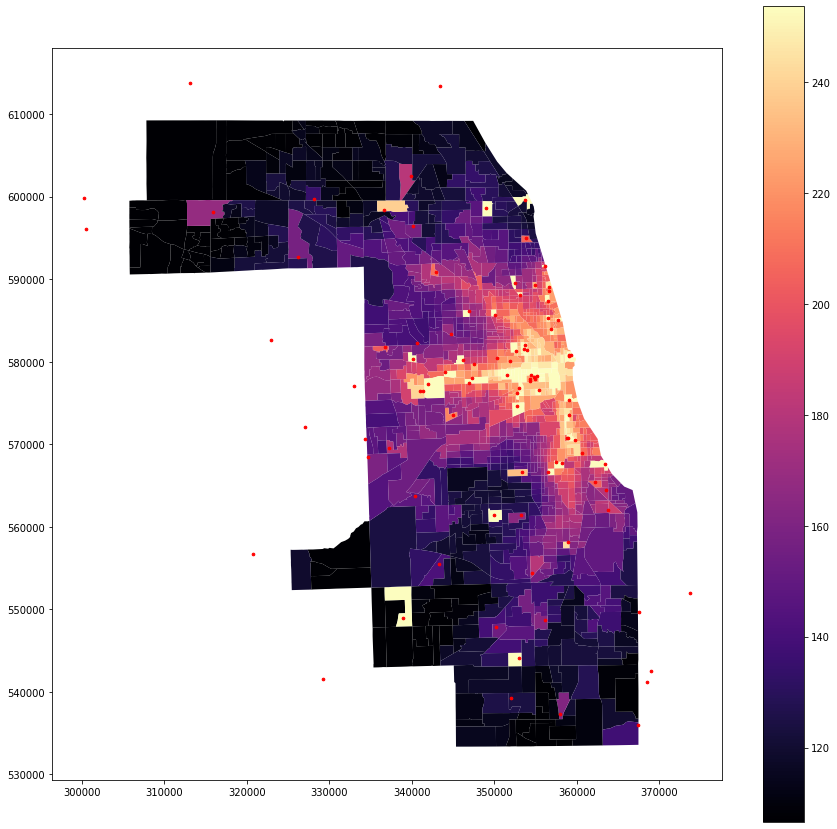

In [14]:
plot_access_measure('gravity_value')

### Custom Weight Step Function
You can also define your own weight function using the `weights.step_fn()` method. In the example below, we show a step function implemented using the `{distance_threshold_1: weight_1, distance_threshold_2: weight_2, ...:..., distance_threshold_n...: weight_n...}` structure where `distance_threshold_n-1 < distance_threshold_n`.

In [15]:
custom_step_fn = weights.step_fn({5:1, 10:.7, 15:.5, 20:.4, 30:.2})
cook_hospital_access.weighted_catchment(name='custom', weight_fn=custom_step_fn)

,custom_value
geoid,
17031010100,4.4
17031010201,4.8
17031010202,5.0
17031010300,5.2
17031010400,5.1
...,...
17031843700,15.1
17031843800,12.5
17031843900,12.0


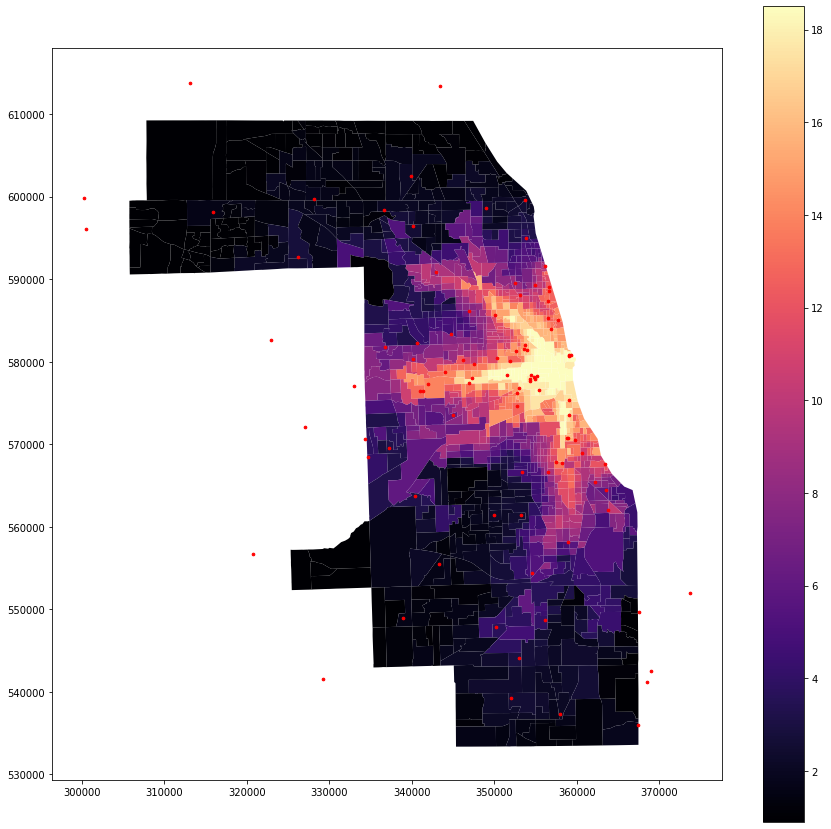

In [16]:
plot_access_measure('custom_value')

## Saving Access Measures to a CSV
Finally, view each of the access measures you've calculated by accessing the `access_df` attribute. You can save your access measures to a csv as shown below.

In [17]:
cook_hospital_access.access_df

,pop,gravity_value,custom_value
geoid,,,
17031010100,4854,130.214432,4.4
17031010201,6450,138.250839,4.8
17031010202,2818,134.848609,5.0
17031010300,6236,134.680466,5.2
17031010400,5042,149.495198,5.1
...,...,...,...
17031843700,2117,206.223543,15.1
17031843800,2110,200.365018,12.5
17031843900,3533,282.596510,12.0


In [18]:
cook_hospital_access.access_df.to_csv('./cook_county_hospital_access_measures.csv')